In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
parkinsons = fetch_ucirepo(id=174) 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

n_estimators = 1024
splits = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]


In [ ]:
def kfold(X_train, y_train, rand_state):
    kf = KFold(n_splits=5, shuffle=True, random_state=rand_state)
    best_score = 0

    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dt = DecisionTreeClassifier(random_state=rand_state)
        dt.fit(X_tr, y_tr)
        scores.append(accuracy_score(y_val, dt.predict(X_val)))

    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score

    return best_score



In [ ]:
def eval_split(X, y, train_size, test_size, rand_state):

    train_acc = []
    test_acc = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =train_size, test_size=test_size, random_state=rand_state)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    
    best_cv_score = kfold(X_train, y_train, rand_state)
    print(f"CV Accuracy: {best_cv_score:.4f}")

    dt = DecisionTreeClassifier(random_state=rand_state)
    dt.fit(X_train, y_train)

    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    test_acc.append(test_accuracy)
    train_acc.append(train_accuracy)

    print(f"Test Accuracy: {test_accuracy:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred_test)

    return test_accuracy, conf_matrix, train_accuracy

In [46]:
def plot_accuracy_curve(results,train_scores, title="Accuracy Curve"):

    test_keys = list(results.keys())
    test_accuracies = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.plot(test_keys, test_accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
    plt.plot(train_scores, marker='o', linestyle='-', color='r', label="Train Accuracy")  
    plt.title(title)
    plt.xlabel("Partitions/Trials")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
CV Accuracy: 0.7914
Test Accuracy: 0.7946
Trial 2:
CV Accuracy: 0.7914
Test Accuracy: 0.7930
Trial 3:
CV Accuracy: 0.7927
Test Accuracy: 0.7919
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
CV Accuracy: 0.7930
Test Accuracy: 0.7966
Trial 2:
CV Accuracy: 0.7986
Test Accuracy: 0.7958
Trial 3:
CV Accuracy: 0.7968
Test Accuracy: 0.7955
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
CV Accuracy: 0.7963
Test Accuracy: 0.7970
Trial 2:
CV Accuracy: 0.7952
Test Accuracy: 0.7964
Trial 3:
CV Accuracy: 0.7978
Test Accuracy: 0.7945

Summary of Test Accuracies:
  Partition Trial 1 20.0% /80.0%: Test Accuracy = 0.7946
  Partition Trial 2 20.0% /80.0%: Test Accuracy = 0.7930
  Partition Trial 3 20.0% /80.0%: Test Accuracy = 0.7919
  Partition Trial 1 50.0% /50.0%: Test Accuracy = 0.7966
  Partition Trial 2 50.0% /50.0%: Test Accuracy = 0.7958
  Partition Trial 3 50.0% 

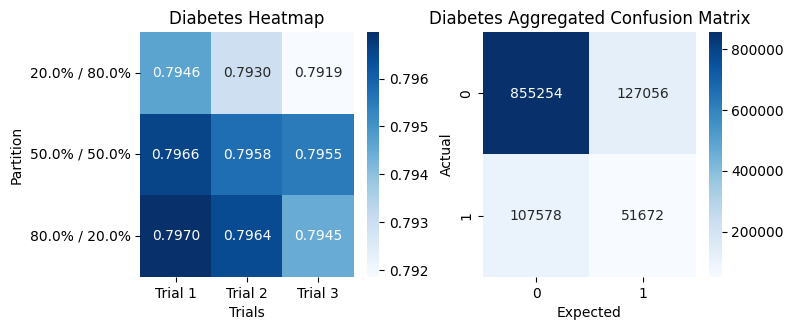

In [ ]:
X= cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
train_results = []
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix, train_accuracy = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        train_results.append(train_accuracy)
        state += 1
    acc_matrix.append(trial_acc)


################## Summary #####################

print("\nSummary of Test Accuracies:")
avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

################## heatmaps and confusion matrix #####################
df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])

plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Diabetes Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Diabetes Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()

plt.show()

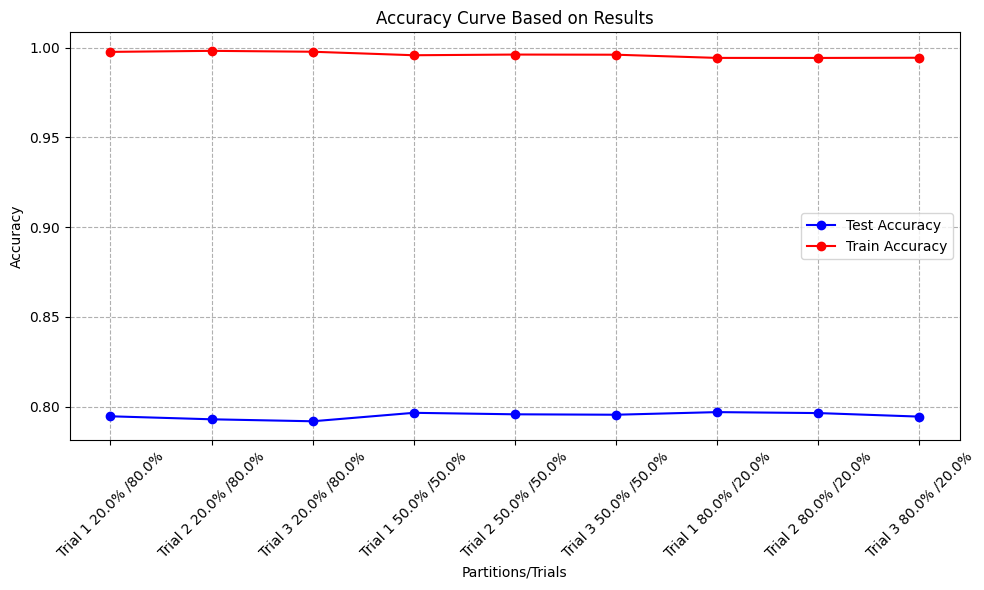

In [52]:
plot_accuracy_curve(results,train_results, title="Accuracy Curve Based on Results")

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
CV Accuracy: 0.7929
Test Accuracy: 0.8013
Trial 2:
CV Accuracy: 0.7679
Test Accuracy: 0.7564
Trial 3:
CV Accuracy: 0.7429
Test Accuracy: 0.8141
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
CV Accuracy: 0.8347
Test Accuracy: 0.8367
Trial 2:
CV Accuracy: 0.8147
Test Accuracy: 0.8571
Trial 3:
CV Accuracy: 0.7726
Test Accuracy: 0.8673
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
CV Accuracy: 0.8589
Test Accuracy: 0.8205
Trial 2:
CV Accuracy: 0.8585
Test Accuracy: 0.7436
Trial 3:
CV Accuracy: 0.8268
Test Accuracy: 0.8974

Summary of Test Accuracies:
  Partition Trial 1 20.0% /80.0%: Test Accuracy = 0.8013
  Partition Trial 2 20.0% /80.0%: Test Accuracy = 0.7564
  Partition Trial 3 20.0% /80.0%: Test Accuracy = 0.8141
  Partition Trial 1 50.0% /50.0%: Test Accuracy = 0.8367
  Partition Trial 2 50.0% /50.0%: Test Accuracy = 0.8571
  Partition Trial 3 50.0% 

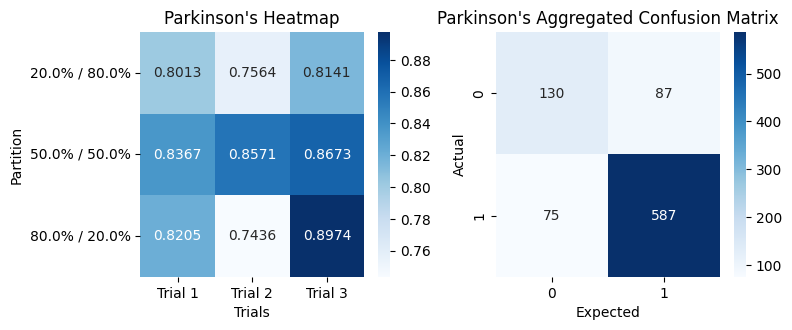

In [54]:
X= parkinsons.data.features
y = parkinsons.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
train_results = []
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix, train_accuracy = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        train_results.append(train_accuracy)
        state += 1
    acc_matrix.append(trial_acc)


################## Summary #####################

print("\nSummary of Test Accuracies:")
avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

################## heatmaps and confusion matrix #####################
df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])

plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Parkinson's Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Parkinson's Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()

plt.show()

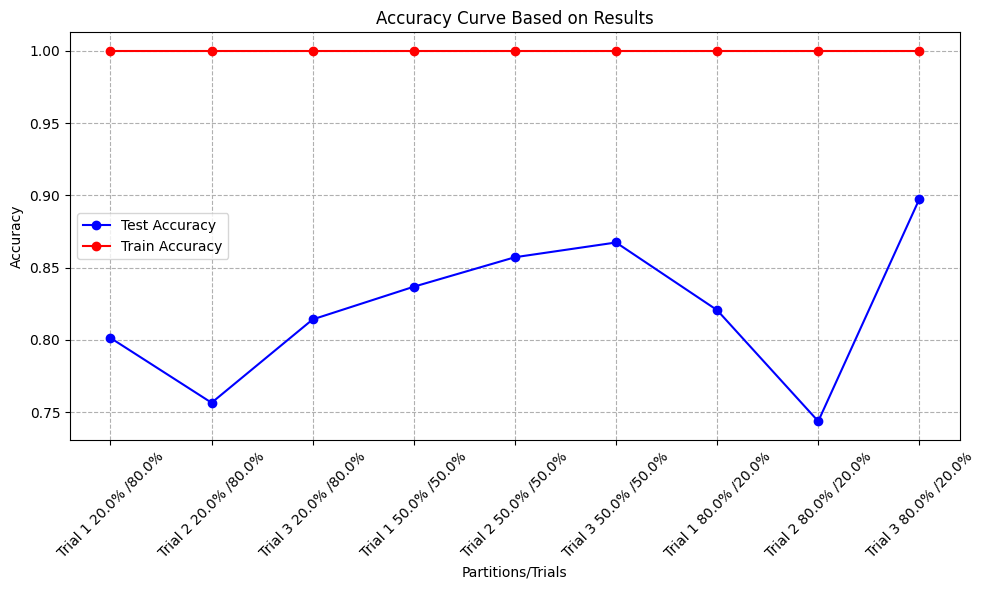

In [55]:
plot_accuracy_curve(results,train_results, title="Accuracy Curve Based on Results")

---------- Partition: Train Size: 20.0% Test Size: 80.0%----------
Trial 1:
CV Accuracy: 0.8675
Test Accuracy: 0.8999
Trial 2:
CV Accuracy: 0.8871
Test Accuracy: 0.8783
Trial 3:
CV Accuracy: 0.9160
Test Accuracy: 0.8934
---------- Partition: Train Size: 50.0% Test Size: 50.0%----------
Trial 1:
CV Accuracy: 0.8803
Test Accuracy: 0.8866
Trial 2:
CV Accuracy: 0.8793
Test Accuracy: 0.8966
Trial 3:
CV Accuracy: 0.8798
Test Accuracy: 0.8803
---------- Partition: Train Size: 80.0% Test Size: 20.0%----------
Trial 1:
CV Accuracy: 0.8858
Test Accuracy: 0.9068
Trial 2:
CV Accuracy: 0.8822
Test Accuracy: 0.8898
Trial 3:
CV Accuracy: 0.8806
Test Accuracy: 0.9029

Summary of Test Accuracies:
  Partition Trial 1 20.0% /80.0%: Test Accuracy = 0.8999
  Partition Trial 2 20.0% /80.0%: Test Accuracy = 0.8783
  Partition Trial 3 20.0% /80.0%: Test Accuracy = 0.8934
  Partition Trial 1 50.0% /50.0%: Test Accuracy = 0.8866
  Partition Trial 2 50.0% /50.0%: Test Accuracy = 0.8966
  Partition Trial 3 50.0% 

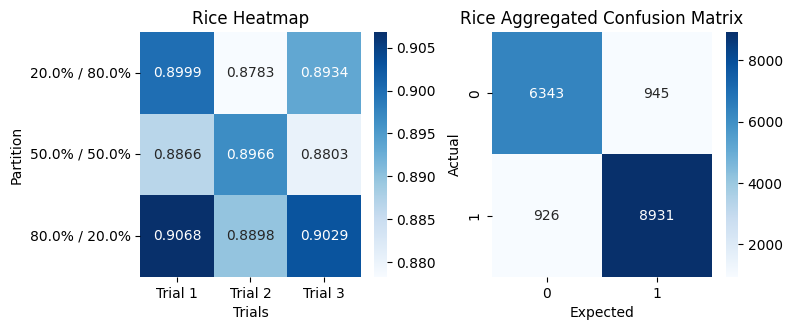

In [56]:
X= rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

y = y.iloc[:, -1]
results = {}
acc_matrix =[]
train_results = []
agg_conf_matrix = np.zeros((2,2))
state = 42
for train_size, test_size in splits:
    trial_acc = []
    print(f"---------- Partition: Train Size: {train_size*100}% Test Size: {test_size*100}%----------")
    for i in range(3):
        print(f"Trial {i + 1}:")
        test_accuracy, conf_matrix, train_accuracy = eval_split(X, y, train_size, test_size, rand_state=state)
        agg_conf_matrix += conf_matrix
        trial_acc.append(test_accuracy)
        results[f"Trial {i + 1} {train_size*100}% /{test_size*100:}%"] = test_accuracy
        train_results.append(train_accuracy)
        state += 1
    acc_matrix.append(trial_acc)


################## Summary #####################

print("\nSummary of Test Accuracies:")
avg_acc = 0
for partition, accuracy in results.items():
    print(f"  Partition {partition}: Test Accuracy = {accuracy:.4f}")
    avg_acc += accuracy
avg_acc /= len(results)

print(f"Average Accuracy =  {avg_acc:.4f}")

################## heatmaps and confusion matrix #####################
df = pd.DataFrame(acc_matrix, columns=[f"Trial {i+1}" for i in range(3)], 
                        index=[f"{train_size*100}% / {test_size*100}%" for train_size, test_size in splits])

plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
sns.heatmap(df, annot=True, cmap='Blues', fmt = '.4f')
plt.title("Rice Heatmap")
plt.xlabel("Trials")
plt.ylabel("Partition")

plt.subplot(2, 2, 2)
sns.heatmap(agg_conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.title("Rice Aggregated Confusion Matrix")
plt.xlabel("Expected")
plt.ylabel("Actual")

plt.tight_layout()

plt.show()

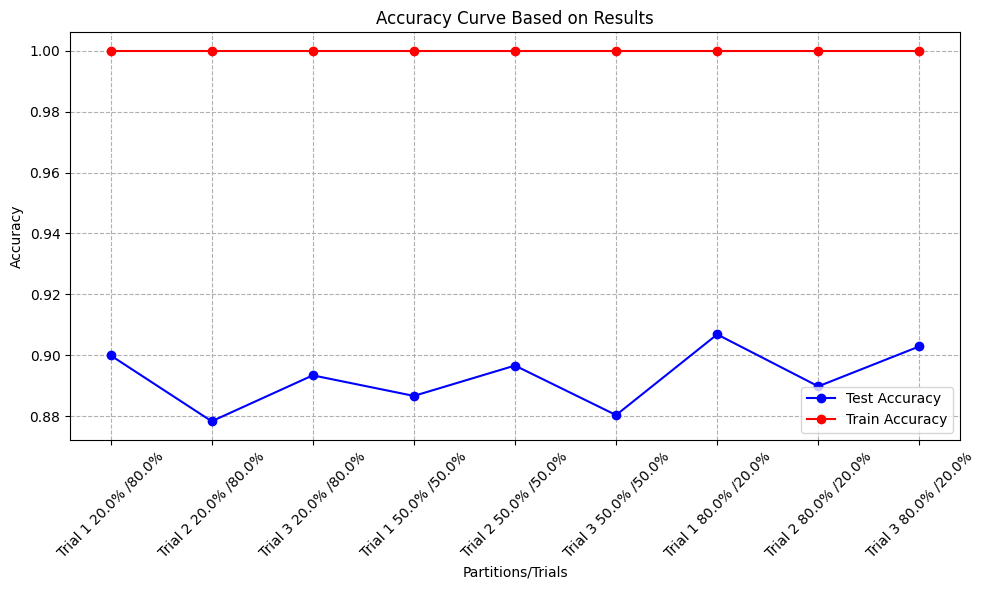

In [57]:
plot_accuracy_curve(results, train_results, title="Accuracy Curve Based on Results")